In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import math
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import time
import warnings

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [8, 5]

In [2]:
D = [2,10,25,50]
pi1 = [0.5, 0.5]
pi2 = [0.1, 0.9]

## Case 1
### $N_d(0_d, I_d)$ and $N_d(\mu_d, I_d)$, where $\mu_d=(d, 0_{d-1})^T$

In [3]:
def gen_data(d):
    mu0, cov0 = np.zeros(d), np.identity(d)
    mu1, cov1 = np.append(np.array([d]), np.zeros(d-1)), np.identity(d)
    PARAMS = (mu0, cov0, mu1, cov1)
    
    X0 = np.random.multivariate_normal(mu0, cov0, size=100)
    Y0 = np.zeros(100)
    X1 = np.random.multivariate_normal(mu1, cov1, size=100)
    Y1 = np.ones(100)
    
    X0_test = np.random.multivariate_normal(mu0, cov0, size=250)
    Y0_test = np.zeros(250)
    X1_test = np.random.multivariate_normal(mu1, cov1, size=250)
    Y1_test = np.ones(250)
    
    X = np.append(X0, X1, axis=0); Y = np.append(Y0, Y1)
    p = np.random.permutation(200)
    X_train = X[p]; Y_train = Y[p]
    
    X = np.append(X0_test, X1_test, axis=0); Y = np.append(Y0_test, Y1_test)
    p = np.random.permutation(500)
    X_test = X[p]; Y_test = Y[p]
    
    return X_train, Y_train, X_test, Y_test, PARAMS

#### (a) : Bayes' Risk

In [4]:
def bayesClassifier(x, Pi, params):
    f0 = sp.stats.multivariate_normal.pdf(x, params[0], params[1])
    f1 = sp.stats.multivariate_normal.pdf(x, params[2], params[3])
    if Pi[0]*f0 >= Pi[1]*f1:
        return 0
    else:
        return 1

In [5]:
def bayesRisk(Pi, d):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    Y_pred = [bayesClassifier(test, Pi, PARAMS) for test in X_test]
    bayesrisk = np.mean(Y_pred != Y_test)    
    print("Bayes Risk: {} | D={} | PI={}".format(bayesrisk, d, Pi))  

In [8]:
for pi in [pi1, pi2]:
    for d in D:
        bayesRisk(pi, d)
    print('-----------------------------------------')

Bayes Risk: 0.152 | D=2 | PI=[0.5, 0.5]
Bayes Risk: 0.0 | D=10 | PI=[0.5, 0.5]
Bayes Risk: 0.0 | D=25 | PI=[0.5, 0.5]
Bayes Risk: 0.0 | D=50 | PI=[0.5, 0.5]
-----------------------------------------
Bayes Risk: 0.242 | D=2 | PI=[0.1, 0.9]
Bayes Risk: 0.0 | D=10 | PI=[0.1, 0.9]
Bayes Risk: 0.0 | D=25 | PI=[0.1, 0.9]
Bayes Risk: 0.0 | D=50 | PI=[0.1, 0.9]
-----------------------------------------


#### (b) : Linear/Quadratic Discriminant Analysis

In [9]:
def LQDA(d, algo='LDA'):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    
    N = len(Y_train)
    N0 = np.sum(Y_train == 0)
    N1 = np.sum(Y_train == 1)
    
    X0 = X_train[Y_train==0]
    X1 = X_train[Y_train==1]

    #parameters estimation
    pi0_est= N0/N
    pi1_est = 1-pi0_est

    mu0_est = np.sum(X0, axis=0)/N0
    mu1_est = np.sum(X1, axis=0)/N1
    
    cov0_est = np.dot((X0-mu0_est).T, X0 - mu0_est)/N0
    cov1_est = np.dot((X1-mu1_est).T, X1 - mu1_est)/N1
    
    if algo=='LDA':
        cov_est = pi0_est*cov0_est + pi1_est*cov1_est        #weighted combination of covariances
        
        train_pred = []
        for i in range(N):
            pred = bayesClassifier(X_train[i], [pi0_est, pi1_est], [mu0_est, cov_est, mu1_est, cov_est])
            train_pred.append(pred)
        train_err = np.mean(train_pred != Y_train)

        test_pred = []
        for i in range(N):
            pred = bayesClassifier(X_test[i], [pi0_est, pi1_est], [mu0_est, cov_est, mu1_est, cov_est])
            test_pred.append(pred)
        test_err= np.mean(test_pred != Y_test)
        
        print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{}'.format(train_err, test_err, d))
        return train_err, test_err
    
    elif algo == 'QDA':
        train_pred = []
        for i in range(N):
            pred = bayesClassifier(X_train[i], [pi0_est, pi1_est], [mu0_est, cov0_est, mu1_est, cov1_est])
            train_pred.append(pred)
        train_err = np.mean(train_pred != Y_train)

        test_pred = []
        for i in range(N):
            pred = bayesClassifier(X_test[i], [pi0_est, pi1_est], [mu0_est, cov0_est, mu1_est, cov1_est])
            test_pred.append(pred)
        test_err= np.mean(test_pred != Y_test)
        print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{}'.format(train_err, test_err, d))
        return train_err, test_err


In [10]:
# Linear Discriminant Analysis
for d in D:
    LQDA(d, algo='LDA')

Missclasification Rate- TRAIN:0.155 | TEST:1.0 | D:2
Missclasification Rate- TRAIN:0.0 | TEST:1.0 | D:10
Missclasification Rate- TRAIN:0.0 | TEST:1.0 | D:25
Missclasification Rate- TRAIN:0.0 | TEST:1.0 | D:50


In [11]:
#Quadratic Discriminant Analysis
for d in D:
    LQDA(d, algo='QDA')

Missclasification Rate- TRAIN:0.17 | TEST:1.0 | D:2
Missclasification Rate- TRAIN:0.0 | TEST:1.0 | D:10
Missclasification Rate- TRAIN:0.0 | TEST:1.0 | D:25
Missclasification Rate- TRAIN:0.0 | TEST:1.0 | D:50


#### (c) : Kernel Discriminant Analysis

In [12]:
def KDEstimate(d, KERNEL):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    mean = np.zeros(d)
    cov = np.identity(d)    
    
    N = len(Y_train)
    N_test = len(Y_test)
    N0 = np.sum(Y_train == 0)
    N1 = np.sum(Y_train == 1)
    
    X0 = X_train[Y_train==0]
    X1 = X_train[Y_train==1]

    #parameters estimation
    pi0_est= N0/N
    pi1_est = 1-pi0_est
    
    
    time1 = time.time()
    
    ## estimating f0
    X0mean = np.mean(X0, axis=0)   
    Z = X0 - X0mean                   #adaptive h using distances between x_i and their mean
    H = np.sum(Z**2, axis=1)**(0.5)
    f0_est = np.zeros(N_test)
    for i in range(N_test):
        Z_i = (X0 - X_test[i])/H.reshape(-1,1)
        if KERNEL == 'gaussian':
            arr = 1/(H**d) * multivariate_normal.pdf(Z_i, mean, cov)
        elif KERNEL == 'uniform':#kernel is identity basically
            arr = 1/(H**d)
        f0_est[i] = np.mean(arr)

    ## estimating f1
    X1mean = np.mean(X1, axis=0)   
    Z = X1 - X1mean                   #adaptive h using distances between x_i and their mean
    H = np.sum(Z**2, axis=1)**(0.5)
    f1_est = np.zeros(N_test)
    for i in range(N_test):
        Z_i = (X1 - X_test[i])/H.reshape(-1,1)
        if KERNEL == 'gaussian':
            arr = 1/(H**d) * multivariate_normal.pdf(Z_i, mean, cov)
        elif KERNEL == 'uniform':#kernel is identity basically
            arr = 1/(H**d)
        f1_est[i] = np.mean(arr)
    
    time2 = time.time() - time1

    #misclassification test error
    Y_pred = []
    for i in range(N_test):
        if pi0_est*f0_est[i] > pi1_est*f1_est[i]:
            Y_pred.append(0)
        else:
            Y_pred.append(1)
    
    missclass_err = np.mean(Y_test != Y_pred)
    print("Test Missclassification Rate: {} | D={} | {}s | KERNEL:{}".format(missclass_err, d, round(time.time()-time1, 3), KERNEL))

In [13]:
for kernel in ['gaussian', 'uniform']:
    for d in D:
        KDEstimate(d, kernel)
    print('--------------------------------')

Test Missclassification Rate: 0.146 | D=2 | 0.191s | KERNEL:gaussian
Test Missclassification Rate: 0.0 | D=10 | 0.209s | KERNEL:gaussian
Test Missclassification Rate: 0.0 | D=25 | 0.275s | KERNEL:gaussian
Test Missclassification Rate: 0.0 | D=50 | 1.699s | KERNEL:gaussian
--------------------------------
Test Missclassification Rate: 0.5 | D=2 | 0.022s | KERNEL:uniform
Test Missclassification Rate: 0.5 | D=10 | 0.033s | KERNEL:uniform
Test Missclassification Rate: 0.5 | D=25 | 0.039s | KERNEL:uniform
Test Missclassification Rate: 0.5 | D=50 | 0.05s | KERNEL:uniform
--------------------------------


#### (d) : K-Nearest Neighbors

In [14]:
def plotit(k, y, xlab, ylab, tit):
    plt.plot(k, y, 'o-')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(tit)
    plt.show()

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

def kNNClassify(k, d):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    clf = KNeighborsClassifier(n_neighbors=k, p=2)
    clf.fit(X_train, Y_train)
    
    train_err = round(1 - clf.score(X_train, Y_train), 3)
    test_err = round(1 - clf.score(X_test, Y_test), 3)
    loocv_err = 1 - np.mean(cross_val_score(clf, X_train, Y_train, cv=sum(Y_train==1)))
    
#     print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{}'.format(train_err, test_err, d))
#     print('Missclasification Rate LOOCV- {} | D:{}'.format(loocv_err, d))
    return train_err, test_err, loocv_err

In [25]:
K = [2,5,10,20,40,80]
d = 2
train_err = []
test_err = []
loocv_err = []
for k in K:
    clf = kNNClassify(k,d)
    train_err.append(clf[0])
    test_err.append(clf[1])
    loocv_err.append(clf[2])

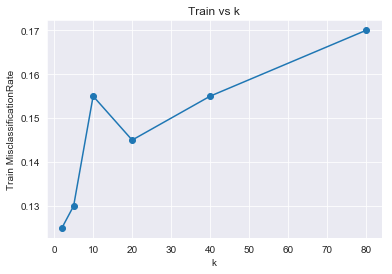

In [26]:
plotit(K,train_err,'k','Train MisclassificationRate','Train vs k')

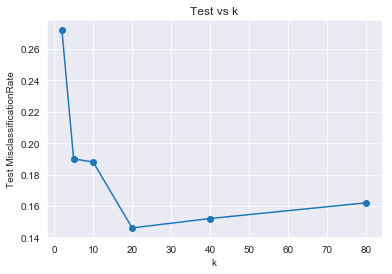

In [27]:
plotit(K,test_err,'k','Test MisclassificationRate','Test vs k')

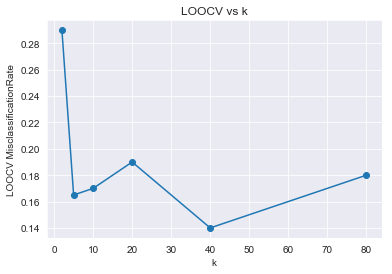

In [23]:
plotit(K,loocv_err,'k','LOOCV MisclassificationRate','LOOCV vs k')

#### (e) : Least Squares Regression with Response Variables

In [43]:
def responseClassify(d):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    N = len(Y_train)
    N0 = np.sum(Y_train == 0)
    N1 = np.sum(Y_train == 1)
    
    Yresp = [-N/N0 if y==0 else N/N1 for y in Y_train]
    alpha = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, Yresp))
    Ypred_train = np.dot(X_train, alpha)
    Ypred_test = np.dot(X_test, alpha)
    
    Ypred_train_clf = [0 if y<0 else 1 for y in Ypred_train]
    Ypred_test_clf = [0 if y<0 else 1 for y in Ypred_test]
    
    train_err = np.mean(Y_train != Ypred_train_clf)
    test_err = np.mean(Y_test != Ypred_test_clf)
    print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{}'.format(round(train_err,3), round(test_err,3), d))

In [44]:
for d in [2,10,25,50]:
    responseClassify(d)

Missclasification Rate- TRAIN:0.235 | TEST:0.252 | D:2
Missclasification Rate- TRAIN:0.22 | TEST:0.254 | D:10
Missclasification Rate- TRAIN:0.17 | TEST:0.252 | D:25
Missclasification Rate- TRAIN:0.08 | TEST:0.26 | D:50


#### (f) : Logistic Discriminant Analysis

In [45]:
from sklearn.linear_model import LogisticRegression

def logClassify(d):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    clf = LogisticRegression()
    clf.fit(X_train, Y_train)
    
    train_err = 1 - clf.score(X_train, Y_train)
    test_err = 1 - clf.score(X_test, Y_test)
    print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{}'.format(round(train_err,3), round(test_err,3), d))


In [46]:
for d in [2,10,25,50]:
    logClassify(d)

Missclasification Rate- TRAIN:0.16 | TEST:0.166 | D:2
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:10
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:25
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:50


#### (g) : Support Vector Machine

In [47]:
from sklearn.svm import SVC

def svmClassify(d, KERNEL):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    clf = SVC(kernel=KERNEL, degree=2) # if poly is chosed degree=2 for quadratic
    clf.fit(X_train, Y_train)
    
    train_err = 1 - clf.score(X_train, Y_train)
    test_err = 1 - clf.score(X_test, Y_test)
    print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{} | KERNEL:{}'.format(round(train_err,3), round(test_err,3), d, KERNEL))

In [48]:
for kernel in ['linear', 'poly', 'rbf']:
    for d in [2,10,25,50]:
        svmClassify(d, KERNEL=kernel)
    print('--------------------------------------------')

Missclasification Rate- TRAIN:0.155 | TEST:0.158 | D:2 | KERNEL:linear
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:10 | KERNEL:linear
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:25 | KERNEL:linear
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:50 | KERNEL:linear
--------------------------------------------
Missclasification Rate- TRAIN:0.225 | TEST:0.25 | D:2 | KERNEL:poly
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:10 | KERNEL:poly
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:25 | KERNEL:poly
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:50 | KERNEL:poly
--------------------------------------------
Missclasification Rate- TRAIN:0.13 | TEST:0.146 | D:2 | KERNEL:rbf
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:10 | KERNEL:rbf
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:25 | KERNEL:rbf
Missclasification Rate- TRAIN:0.0 | TEST:0.0 | D:50 | KERNEL:rbf
--------------------------------------------
